In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from models import KuraNet
from train import optimize_connectivity_net
from data import make_data, make_all_data, make_data2
from utils import yield_zero_column, circular_variance
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# Generate Data

In [2]:
from os.path import expanduser
home = expanduser("~")
data_base_dir = os.path.join(home,'global_synchrony_1')
if not os.path.exists(data_base_dir): os.makedirs(data_base_dir)

num_samples=10000
data_names=['omega', 'h', 'tau']
dist_names = ['uniform1', 'degenerate', 'degenerate']
# dist_names = ['uniform1', 'uniform1', 'degenerate']
# dist_names = ['uniform2', 'degenerate', 'negative_binomial']

# Uncomment second and third lines if h and tau are not dirac distributions
make_data2(data_names[0], dist_names[0], data_base_dir=data_base_dir, num_samples=num_samples)
# make_data(dist_names[1], data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)
# make_data(dist_names[2], data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)

# make_all_data(num_samples=args.num_samples,data_dir=args.data_dir)


Generating omega train data
Generating omega test data


In [3]:
train_features = np.load(os.path.join(data_base_dir, data_names[0], dist_names[0],'train','0','features.npz'))
test_features = np.load(os.path.join(data_base_dir, data_names[0], dist_names[0],'test','0','features.npz'))

In [8]:
train_features['y']

array(0)

In [7]:
train_ds = TensorDataset(torch.FloatTensor(train_features['x']), torch.LongTensor(train_features['y'].astype(np.int32)))
test_ds = TensorDataset(torch.FloatTensor(test_features['x']), torch.LongTensor(test_features['y'].astype(np.int32)))
train_dl          = DataLoader(train_ds, batch_size=100, shuffle=True, drop_last=True)
test_dl          = DataLoader(test_ds, batch_size=1000, shuffle=True, drop_last=True)

NameError: name 'num_units' is not defined

# Set Training Parameters

In [3]:
seed=0
num_units=100
avg_deg=1.0
num_epochs=2 # For tau, use 2
batch_size=100
burn_in_steps=100
gd_steps=50
alpha=.1
solver_method='euler'
rand_inds=False
adjoint=False
loss_type='circular_variance'
optimizer='SGD' # For tau, use SGD
momentum=0.0  # For tau, use .5
max_grad_norm=10.0 # For tau, use 5.0
num_hid_units=128
lr=5e-4 # For tau, use 5e-2
device='cuda'
num_batches = int(num_samples/num_units)

# Load training and testing data.
train_dirs = {}
test_dirs  = {}
train_dss  = {}
test_dss   = {}
train_dls  = {}
test_dls   = {}

for dist_name, data_name in zip(dist_names, data_names):
    if dist_name != 'degenerate':
        train_dirs[data_name] = os.path.join(data_base_dir, dist_name, 'train')
        test_dirs[data_name] = os.path.join(data_base_dir, dist_name, 'test')
        train_dss[data_name] = DatasetFolder(train_dirs[data_name], np.load, 'npy')
        test_dss[data_name] = DatasetFolder(test_dirs[data_name], np.load, 'npy')
        train_dls[data_name] = DataLoader(train_dss[data_name], batch_size=num_units, shuffle=False, drop_last=True)
        test_dls[data_name] = DataLoader(test_dss[data_name], batch_size=num_units, shuffle=False, drop_last=True)
    else:
        train_dls[data_name] = yield_zero_column(num_batches,num_units)
        test_dls[data_name] = yield_zero_column(num_batches,num_units)

# Run Training

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)

loss_train, loss_test, kn, cx = optimize_connectivity_net(num_units, train_dls, test_dls, avg_deg=avg_deg,
                                                      pretrained=False,  num_epochs=num_epochs, batch_size=num_units,
                                                      burn_in_steps=burn_in_steps, gd_steps=gd_steps,alpha=alpha,
                                                      solver_method=solver_method, adjoint=adjoint,
                                                      loss_type=loss_type, optimizer=optimizer,
                                                      lr=lr, momentum=momentum, max_grad_norm=max_grad_norm,
                                                      num_hid_units=num_hid_units, verbose=1, show_every=10,
                                                      num_eval_batches=10, rand_inds=rand_inds, device=device)


Training. Epoch 0.
Training batch: 0. Time/Batch: 0.39. Loss: 0.6313409805297852. Gradient norm: 5.450124842255002.
Training batch: 10. Time/Batch: 0.3559. Loss: 0.5604900121688843. Gradient norm: 4.6596856768871255.
Training batch: 20. Time/Batch: 0.366. Loss: 0.6775163412094116. Gradient norm: 5.6927174599613775.
Training batch: 30. Time/Batch: 0.3651. Loss: 0.3427678644657135. Gradient norm: 6.083407305218589.
Training batch: 40. Time/Batch: 0.3651. Loss: 0.4587574005126953. Gradient norm: 4.788072759716986.
Training batch: 50. Time/Batch: 0.361. Loss: 0.38685280084609985. Gradient norm: 5.663271627014511.
Training batch: 60. Time/Batch: 0.3826. Loss: 0.32803916931152344. Gradient norm: 2.646761055390468.
Training batch: 70. Time/Batch: 0.3588. Loss: 0.2621384263038635. Gradient norm: 2.410407421973891.
Training batch: 80. Time/Batch: 0.3638. Loss: 0.29822278022766113. Gradient norm: 6.061884506749776.
Training batch: 90. Time/Batch: 0.3637. Loss: 0.16585421562194824. Gradient norm:

# Visualization

Optimized loss: 0.0671
Control loss: 0.6442


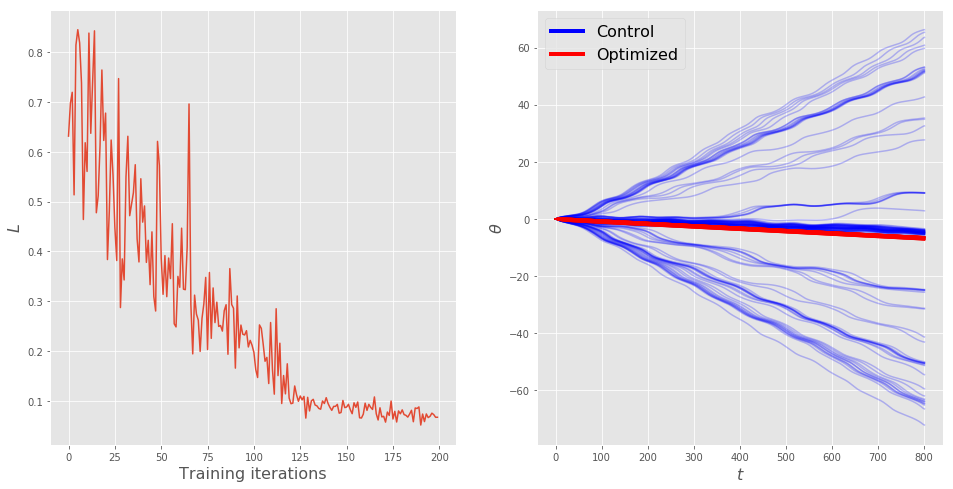

In [7]:
visualization_time=800
kn_control = KuraNet(3, avg_deg=avg_deg, num_hid_units=num_hid_units,
                      rand_inds=rand_inds,
                      adjoint=adjoint, solver_method=solver_method,
                      alpha=alpha, gd_steps=1,
                      burn_in_steps=visualization_time).to(device)
kn_control.set_batch_size(batch_size)

kn.set_grids(alpha, visualization_time, 1)
data_keys = [key for key in train_dls.keys()]

# Load one testing batch
for j, X in enumerate(zip(*[test_dls[key] for key in data_keys])):
    x = {key : y.to(device) for (key, (y,_)) in zip(data_keys, X)}
    # Fix max delay for memory problems
    if 'tau' in x.keys():
        x['tau']  = torch.where(x['tau'] > 40.0, 40.0 * torch.ones_like(x['tau']),x['tau'])
    break
    
flow = kn.run(x)
flow_control = kn_control.run(x)
print('Optimized loss: %.04f' % circular_variance(flow[burn_in_steps:]))
print('Control loss: %.04f' % circular_variance(flow_control[burn_in_steps:]))

flow = flow.data.cpu().numpy() 
flow_control=flow_control.data.cpu().numpy()

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color='b', lw=4),
         Line2D([0], [0], color='r', lw=4)]


fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(loss_train)
axes[0].set_xlabel('Training iterations', fontsize=16)
axes[0].set_ylabel(r'$L$', fontsize=16)
axes[1].plot(flow_control, color='b', alpha=.25)
axes[1].plot(flow, color='r', alpha=.25)
axes[1].legend(lines, ['Control', 'Optimized'], fontsize=16)
axes[1].set_xlabel(r'$t$', fontsize=16)
axes[1].set_ylabel(r'$\theta$', fontsize=16)
plt.show()
plt.close()

# Animation

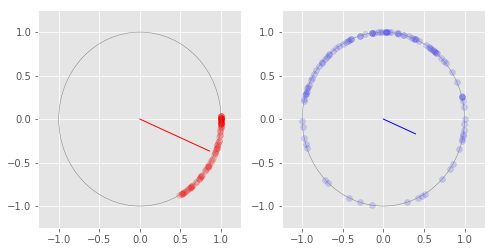

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
rc('animation', html='html5')
import ipdb

fig, axes = plt.subplots(1,2,figsize=(8,4))
flow_x         = np.cos(flow)
flow_x_control = np.cos(flow_control)
flow_y         = np.sin(flow)
flow_y_control = np.sin(flow_control)

frames = flow.shape[0]

def update(i):
    for ax, sc, ln, fl, fl_cmp in zip(axes, [scatter0,scatter1],[line0, line1], [flow, flow_control], [[flow_x, flow_y], [flow_x_control, flow_y_control]]):
        angle = fl[i,...].mean()
        state = np.concatenate((fl_cmp[0][i,...].reshape(-1,1), fl_cmp[1][i,...].reshape(-1,1)),axis=-1)
        cv = circular_variance(torch.tensor(fl[i,...])).numpy()
        sc.set_offsets(state)
        ln.set_data([0, (1-cv)*np.cos(angle)],[0, (1-cv)*np.sin(angle)])
    return scatter0,scatter1,line0,line1,

scatters = []
lines = []
for ax, cl, fl, fl_cmp in zip(axes, ['r','b'],[flow, flow_control], [[flow_x, flow_y], [flow_x_control, flow_y_control]]):
    ax.set_xlim(( -1.25, 1.25))
    ax.set_ylim((-1.25, 1.25))
    ax.add_patch(plt.Circle((0, 0), 1.0, color='gray', fill=False))
    scatter = ax.scatter(fl_cmp[0][0,...], fl_cmp[1][0,...], color=cl, alpha=.15)
    angle = fl[0,...].mean()
    state = np.concatenate((fl_cmp[0][0,...].reshape(-1,1), fl_cmp[1][0,...].reshape(-1,1)),axis=-1)
    cv = circular_variance(torch.tensor(fl[0,...])).numpy()
    line, = ax.plot([0, (1-cv)*np.cos(angle)],[0, (1-cv)*np.sin(angle)], color = cl, linewidth = 1)
    lines.append(line)
    scatters.append(scatter)

scatter0 = scatters[0]
scatter1 = scatters[1]
line0 = lines[0]
line1 = lines[1]

anim = FuncAnimation(fig, update, frames=frames, blit=True)
# HTML(anim.to_html5_video())
anim.save(os.path.join(home, 'kuramoto.mp4'), writer='ffmpeg', fps=45)
# # anims.append(HTML(anim.to_html5_video()))
# #     anim